Link to Jupyter notebook: [2.feature-selection.ipynb](./2.feature-selection.ipynb)

## Introduction to feature selection

In machine learning, feature selection is need for several reasons:

* (Interpretation) We want to know which features are most relevant.
* (Computation) With fewer features, computation is more efficient in terms of time and memory.
* (Performance) After filtering irrelevant features, the model is less prone to overfitting.

In general, feature selection methods fall into three categories:

**Filter methods**

Feature selection is performed independently of the predictor. Usually filter methods are
the fastest and simplest way do feature selection. Every feature or a group of features is
evaluated in each step, and features that pass a given criteron are kept.

**Wrapper methods**

Different from filter methods in that a complex predictor is used to rank the features, 
which combines all features to make a prediction. Ideally, all subsets can be evaluated to get
the best subset. However, greedy algorithms (e.g. sequential feature selection)
and stochastic algorihtms are often used instead
of best subset selection because the number of subsets increase exponentially with the number
of features. Wrapper methods may be stuck in local minima if they cannot explore the whole feature
subset space. Wrapper methods often require large computation resources especially the computational complexity
of the predictor is high.

**Embedded methods**

Feature selection is embedded into a prediction algorithm, which is typically implemented by
adding a regularization term, either explicitly or implicitly. Feature interdependence is considered by
embedded methods. Compared to wrapper methods, the computational complexity embedded methods is lower.

## Import required Python packages

In [1]:
%pylab inline
import pandas as pd
# For machine learning
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, \
    roc_curve, precision_recall_curve, average_precision_score, matthews_corrcoef, confusion_matrix
# For plotting
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


## Seed the random number generator

To make the randomly generated dataset reproducible, we fixed seed of the
[numpy pseudo-random number generator](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.RandomState.html).

In [2]:
random_state = np.random.RandomState(654321)

## Generate dataset

In [3]:
n_samples = 1000
n_features = 50

X, y = make_classification(n_samples=n_samples, n_classes=2, n_features=n_features,
                           n_informative=3, n_redundant=2, n_clusters_per_class=2,
                           class_sep=0.8, random_state=random_state)

## Univariate feature selection

Univariate feature selection removes features by calculating a statistical score for individual features
only select features with high-ranking scores. Scores for each feature is calculated independently,
make this method very efficient and can be performed in parallel.
Univariate feature selection is useful when the number of features is very large, compared to the number samples.

In univariate feature selection, scores are typically evaluated between input features and class labels/target variables. For classification problems, continous features can be scored using various statistical test, 
including [Mann-Whitney U tests](https://en.wikipedia.org/wiki/Mann–Whitney_U_test),
[t-tests](https://en.wikipedia.org/wiki/Student%27s_t-test),
[ANOVA models](https://en.wikipedia.org/wiki/Analysis_of_variance),
area under the ROC curve (AUROC). 
ANOVA models can accomodate multi-class labels.
For discrete features, chi-square test, mutual information or gini index are useful criteria.

For regression problems, correlation coefficient or F-tests can be used for feature selection.

Unsupervised filters do not use information about target variables, but can greatly reduce the number of features
and is less prone to overfitting. Commonly used filters include non-zero fraction and variance.
Sparse datasets contain large numbers of missing/zero values and features with too many missing values can be removed.
Features with larger variance are probably more informative about target values.

After calculating scores for each feature, we can simply select features according to k highest scores
or a fixed threshold. If p-values of a statistical test are available, we can select p-values according to
a given false positive rate (FPR), false discovery rate (FDR) or Family-wise error rate (FWE).

Features according to [false positive rate (FPR)](https://en.wikipedia.org/wiki/False_positive_rate) are selected as:
$$ p(x_k) \le \alpha $$

Features according to [family-wise error rate (FWER)](https://en.wikipedia.org/wiki/Family-wise_error_rate)
(also called [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction))
are selected as:
$$ p(x_k) \le \frac{1}{M} \alpha $$

Features according to false discovery rate (FDR) are selected by first sorting pvalues in accending order
and then select significant features according the following criterion 
([Benjamini-hochberg procedure](https://en.wikipedia.org/wiki/False_discovery_rate)):
$$ p(x_k) \le \frac{k}{M} \alpha $$

Because univariate feature selection considers each feature independently, redundant features may be selected.

### ANOVA F-test (classification)

In [4]:
from sklearn.feature_selection import GenericUnivariateSelect, f_classif

selector = GenericUnivariateSelect(f_classif, mode='k_best', param=10)
selector.fit(X, y)

GenericUnivariateSelect(mode='k_best', param=10,
            score_func=<function f_classif at 0x7efce2631b70>)

[]

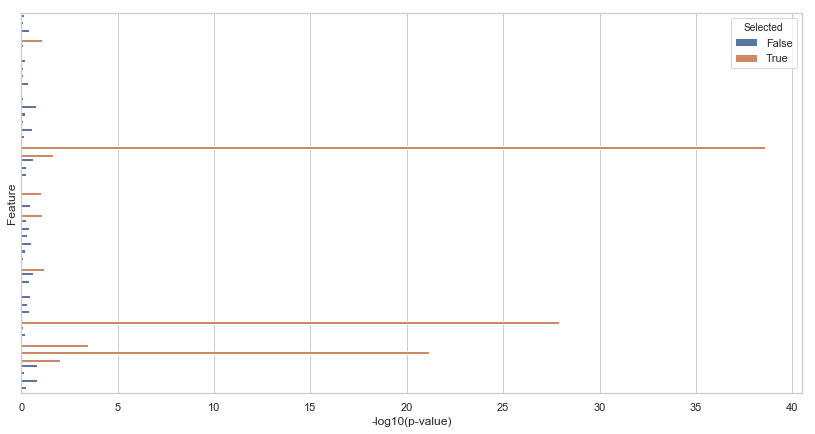

In [5]:
plot_data = pd.DataFrame({
    '-log10(p-value)': -np.log10(selector.pvalues_),
    'Feature': np.arange(n_features),
    'Selected': selector.get_support()
})
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x='-log10(p-value)', y='Feature', hue='Selected', orient='h',
            data=plot_data, ax=ax)
ax.set_yticks([])

### Linear regression F-test (regression)

[]

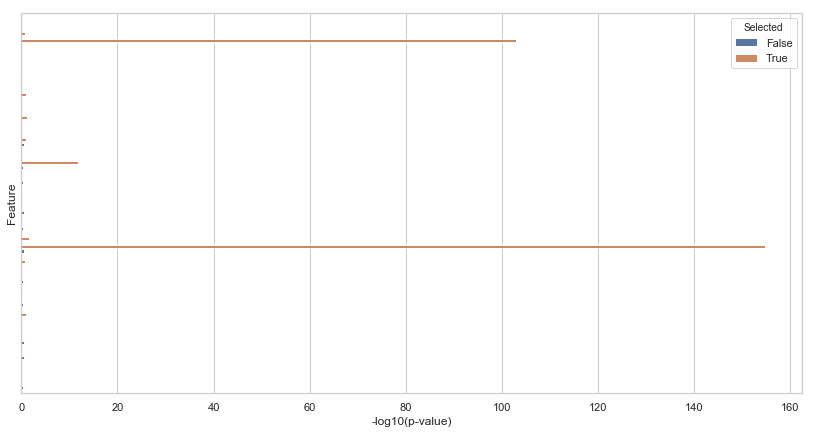

In [6]:
from sklearn.feature_selection import f_regression

n_samples = 1000
n_features = 50
X_reg, y_reg = make_regression(n_samples=n_samples, n_features=n_features,
                       n_informative=3, noise=1, random_state=random_state)

selector = GenericUnivariateSelect(f_regression, mode='k_best', param=10)
selector.fit(X_reg, y_reg)

plot_data = pd.DataFrame({
    '-log10(p-value)': -np.log10(selector.pvalues_),
    'Feature': np.arange(n_features),
    'Selected': selector.get_support()
})
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x='-log10(p-value)', y='Feature', hue='Selected', orient='h',
            data=plot_data, ax=ax)
ax.set_yticks([])

## External validation

It is a common mistake to do feature selection on the whole dataset prior to external validation such as
cross-validation. It should be realized that many feature selection process already uses information
of class labels/target variables and can overfit. Feature selection should be included as part of
model training process and only use training data.

A typical workflow is:

```python
scores = [0 for i in range(resample_rounds)]
for i in range(resample_rounds):
    X_train, y_train, X_test, y_test = resample(X, y)
    features = select_features(X_train, y_train)
    predictor = Predictor()
    predictor.fit(X_train[:, features], y_train)
    y_pred = predictor.predict(X_test[:, features])
    scores[i] = evaluate(y_test, y_pred)
mean_score = mean(scores)
```

For unsupervised feature selection methods, feature selection can be performed outside the validation loop.

## Recursive feature elimination (RFE)



Text(0,0.5,'Feature')

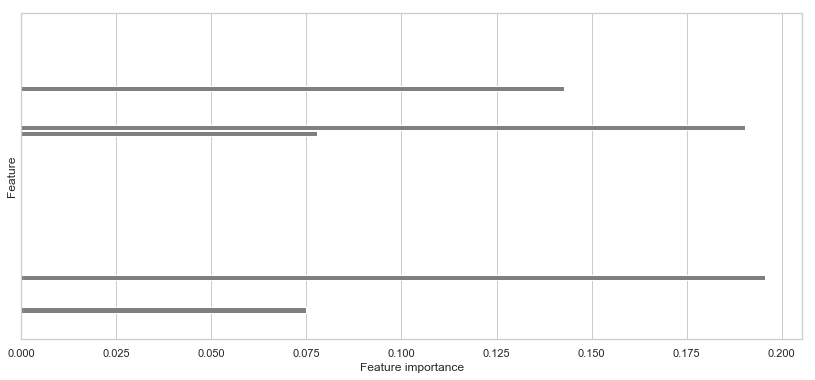

In [7]:
from sklearn.feature_selection import RFECV

model = LinearSVC()
cv = RFECV(model, cv=3, step=0.1)
cv.fit(X, y)

fig, ax = plt.subplots(figsize=(14, 6))
feature_importances = np.zeros(n_features)
feature_importances[cv.support_] = np.abs(np.ravel(cv.estimator_.coef_))
sns.barplot(x=feature_importances, y=np.arange(n_features), color='gray', orient='h',
            ax=ax)
ax.set_yticks([])
ax.set_xlabel('Feature importance')
ax.set_ylabel('Feature')

## Sequential Forward Selection (SFS)

Sequential feature selection (SFS) is a greedy algorithm for best subset feature selection.
SFS is wrapper method that ranks features according to a prediction model.
SFS starts with an empty feature set. During each step, SFS tries to add a feature from remaining
features to the current feature set and train the predictor on the new feature set.
A given metric (e.g. accuracy) is used to evaluate the prediction performance on the feature set.
Optionally, cross-validation can be used to prevent overfitting.
After enumerating all remaining features, SFS keeps a feature with the highest prediction performance
and add the feature to the current feature set. The feature stops when a desired number of features
are selected.

Because SFS retrain the model for every remaining feature and for every step, it demands huge computational
resources when the desired number of features is large. For this reason, SFS is recommended only when we
want to select a small number of features.

Due to the greedy nature of the SFS algorithm, the selected feature subset is not optimal.
To overcome local minima, stochastic algorithms such as genetic algorithm (GA) or other types of randomness can
be included in the algorithm.

(0.5, 1)

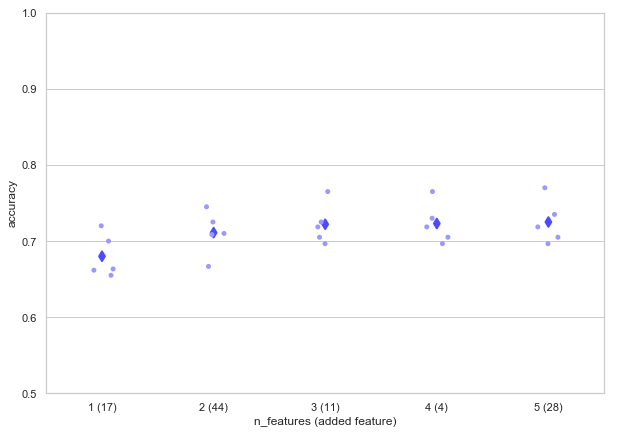

In [8]:
from mlxtend.feature_selection import SequentialFeatureSelector

model = LogisticRegression()
sfs = SequentialFeatureSelector(model, k_features=5,
                                forward=True, floating=False, scoring='accuracy', cv=5)
sfs.fit(X, y)

added_features = []
for i in range(1, len(sfs.subsets_) + 1):
    if i == 1:
        added_features.append(sfs.subsets_[i]['feature_idx'][0])
    else:
        added_features.append(list(set(sfs.subsets_[i]['feature_idx']) - set(sfs.subsets_[i - 1]['feature_idx']))[0])
added_features

plot_data = pd.DataFrame(np.column_stack([sfs.subsets_[i]['cv_scores'] for i in sfs.subsets_]))
plot_data = pd.melt(plot_data, var_name='n_features', value_name='accuracy')
fig, ax = plt.subplots(figsize=(10, 7))
sns.stripplot('n_features', 'accuracy', color=(0.6, 0.6, 1.0), data=plot_data, ax=ax)
sns.pointplot('n_features', 'accuracy', color=(0.3, 0.3, 1.0), data=plot_data, 
              join=False, ci=None, ax=ax, markers='d')
ax.set_xticklabels(['{} ({})'.format(i + 1, feature) for i, feature in enumerate(added_features)])
ax.set_xlabel('n_features (added feature)')
ax.set_ylim(0.5, 1)

## Embedded feature selection






### LASSO

LASSO is a linear model with L1 regularization on the coefficients.
$$ \text{Loss} = \sum_{i=1}^N error(\mathbf{w}^{T} \mathbf{x}_i + b, y_i) + \alpha ||\mathbf{w}||_1 $$
where
$$ ||\mathbf{w}||_1 = \sum_{k=1}^M |w_k| $$

The error function depends on the prediction problem. 
For classification, a Logistic/sigmoid function transforms the linear combination to a class probability
between 0 and 1. Then a negative log-likelihood/cross-entropy between predicted probability
and true class labels is used as the error function.
For regression, squared error is used as the error function.

LASSO generate sparse coefficients (with many zero coefficients) through the L1 regularization term.
The loss function of LASSO can be rewritten as a constrained optimization problem. Because
the feasible region contains many corners anchored at the axes (zero values on some dimensions),
there is high probability that the contour of an objective function will hit one of the corners.
The regularization strength $\alpha$ controls the sparseness of the solution.
Typically, grid search is used to optimize hyper-parameter $\alpha$ according to cross-validation scores.
$\alpha$ is commonly choosen on a exponential scale (e.g. from $10^{-6}$ to $10^{6}$).

Optimized C = 0.1


Text(0,0.5,'Feature')

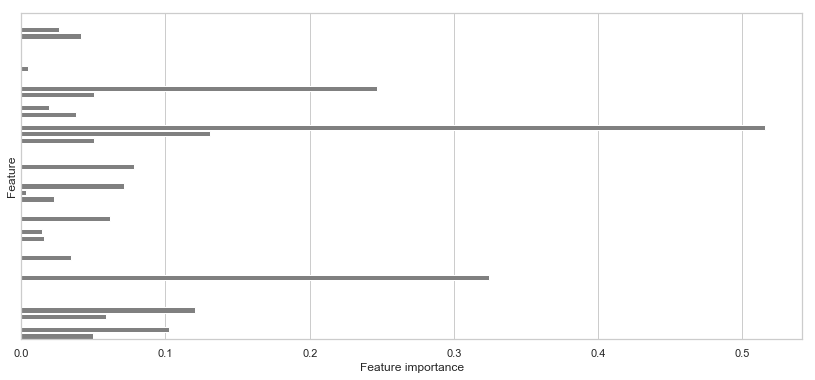

In [9]:
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(Cs=10**np.arange(-6, 7, dtype='float'),
                             penalty='l1', dual=False, solver='liblinear')
model.fit(X, y)

print('Optimized C = {}'.format(model.C_[0]))

fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x=np.abs(np.ravel(model.coef_)), y=np.arange(n_features), color='gray', orient='h',
            ax=ax)
ax.set_yticks([])
ax.set_xlabel('Feature importance')
ax.set_ylabel('Feature')

### Elastic net

Elastic net is also a linear model, but combines L1 and L2 regularization.
L2 regularization penalize more on coefficient values to prevent overfitting and colinearity
(linear correlation between features).
L1 regularization focus more on sparseness, but is susceptible to colinearity and may also 
generate large weights.

$$ \text{Loss} = \sum_{i=1}^N \text{error}(\mathbf{w}^{T} \mathbf{x}_i + b, y_i) 
+ \alpha [ \theta \cdot ||\mathbf{w}||_1
+ (1 - \theta) \cdot ||\mathbf{w}||_2^2 ] $$
where
$$ ||\mathbf{w}||_2^2 = \sum_{k=1}^M w_k^2 $$

Elastic net contains two hyper-paremeters: $\alpha$ and $\theta$. The additional parameter $\theta$
controls the ratio between L1 and L2 regularization. When $\theta = 1$, it becomes LASSO.
When $\theta = 0$, it becomes RIDGE (with only L2 regularization).

Text(0,0.5,'Feature')

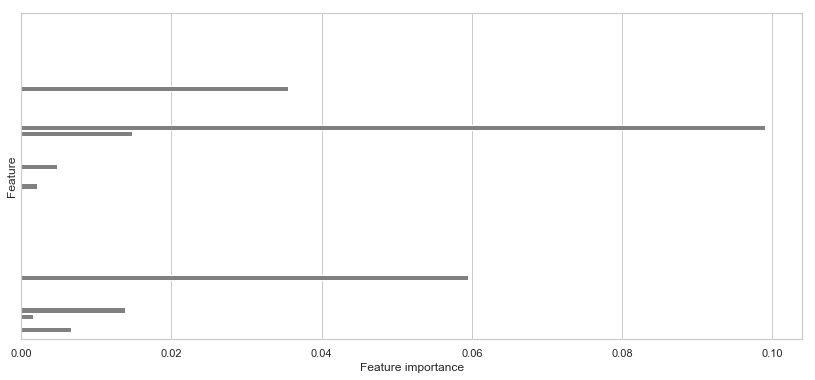

In [10]:
from sklearn.linear_model import ElasticNetCV

model = ElasticNetCV(l1_ratio=0.5)
model.fit(X, y)

fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x=np.abs(np.ravel(model.coef_)), y=np.arange(n_features), color='gray', orient='h',
            ax=ax)
ax.set_yticks([])
ax.set_xlabel('Feature importance')
ax.set_ylabel('Feature')

### Decision tree

Decision tree is a rule-based predictor. Each rule is a criterion on one feature.
Each rule/node separate the samples into two subsets with increases homogeneity/purity.
Each node grows until all samples are perfectly separated (all leave nodes contains 
samples from a single class) or a given maximum depth is reached.

If a subset of features is sufficient to separate all samples, these features formed the selected feature set.
Alternatively, we can select features according to feature importance.
After a decision tree has been built, feature importances are calculated as the sum of weighted number of rules
used in the tree.

Text(0,0.5,'Feature')

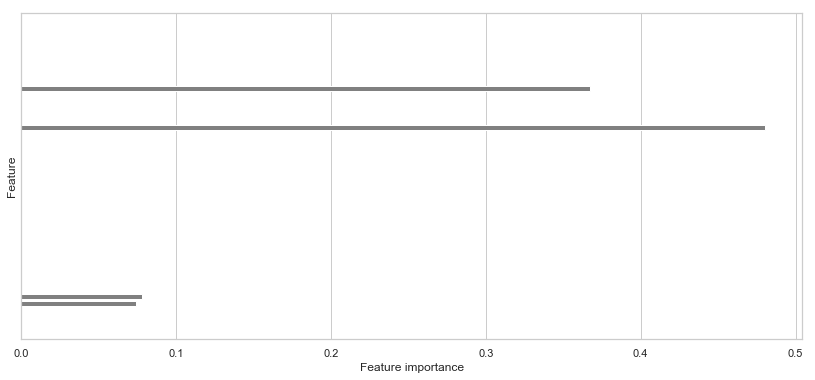

In [11]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
cv = GridSearchCV(model, param_grid={'max_depth': list(range(1, 10))}, cv=3)
cv.fit(X, y)
model = cv.best_estimator_

fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x=np.abs(np.ravel(model.feature_importances_)), y=np.arange(n_features), color='gray', orient='h',
            ax=ax)
ax.set_yticks([])
ax.set_xlabel('Feature importance')
ax.set_ylabel('Feature')

We can use the [sklearn.tree.export_graphviz](http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html)
to visualize the rules in the tree.

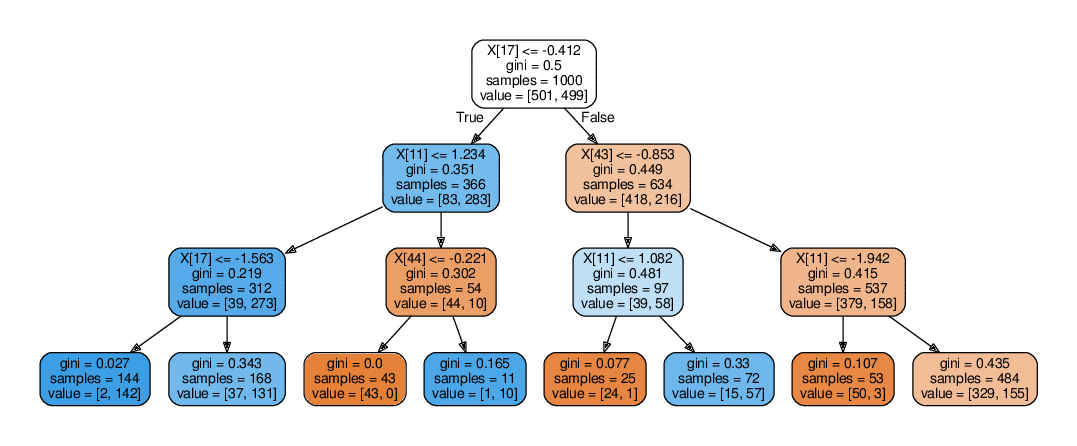

In [12]:
import graphviz
from sklearn.tree import export_graphviz
from wand.image import Image as WImage

graph_data = export_graphviz(model, out_file=None, filled=True, rounded=True) 
graph = graphviz.Source(graph_data) 
graph.render('decision_tree')
WImage(filename='decision_tree.pdf', resolution=72)

### Random forest

Random forest is an ensemble algorithm that combines predictions of many decision trees.
Randomness is incorporated into each decision tree by bootstraping training samples or tree building process.
A single decision tree is easy to overfit because it tries to separate samples perfectly
but realistic data usually contains noise features. Due to randomness in training individual decision trees,
each tree may give different predictions for a sample. These predictions/votes are combined through 
majority rule. The fraction of decision trees that contribute to the prediction defines the confidence/probability
of the prediction. The ensemble strategy inherits the advantage of decision tree in non-learn modeling of data
and is robust against overfitting, which makes random forest an off-the-shelf algorithm
for a general machine learning problem.

This example uses grid search with cross-validation to optimize two hyper-parameters:
max tree depth and number of trees. Finally, it computes feature importances by averageing feature importances
of individual trees. The feature importances are not as sparse as decision trees, but a few features
stand out among others.

Optimized hyper-parameters: max_depth = 4, n_estimators = 4


Text(0,0.5,'Feature')

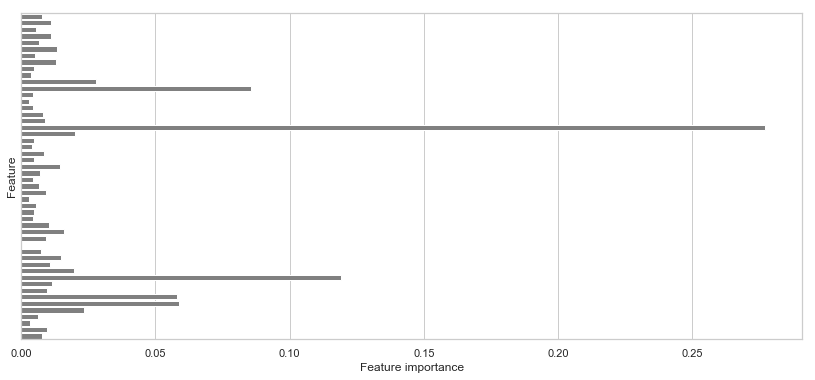

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
cv = GridSearchCV(model, param_grid={
    'max_depth': list(range(1, 5)),
    'n_estimators': list(range(10, 60, 10))},
    cv=3)
cv.fit(X, y)
model = cv.best_estimator_
print('Optimized hyper-parameters: max_depth = {}, n_estimators = {}'.format(
    cv.best_estimator_.max_depth, cv.best_estimator_.max_depth))

fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x=np.abs(np.ravel(model.feature_importances_)), y=np.arange(n_features), color='gray', orient='h',
            ax=ax)
ax.set_yticks([])
ax.set_xlabel('Feature importance')
ax.set_ylabel('Feature')

## Homework

1. Understand and run code in this tutorial on a Jupyter notebook.
2. Try univariate feature selection using FDR, FWER, FPR and compare features selected by each method.
3. Implement recursive feature elimination (RFE) by yourself. Eliminate 10% features in each round. Plot cross-validation scores (ROAUC) vs number of features.
4. Try varying the regularization parameter ($\alpha$ and $\theta$) in LASSO and elastic net and see how they affect the selected features and coefficients.

## Further reading

1. Chandrashekar, G., and Sahin, F. (2014). A survey on feature selection methods. Computers & Electrical Engineering 40, 16–28.
2. Guyon, I., and Elisseeff, A. (2003). An Introduction to Variable and Feature Selection. J. Mach. Learn. Res. 3, 1157–1182.
3. Saeys, Y., Inza, I., and Larrañaga, P. (2007). A review of feature selection techniques in bioinformatics. Bioinformatics 23, 2507–2517.